In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from mlxtend.frequent_patterns import apriori, association_rules,fpgrowth
from mlxtend.preprocessing import TransactionEncoder
from pyECLAT import ECLAT

<h3>EDA</h3>

In [2]:
users = pd.read_csv('Users.csv')

In [3]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [4]:
users['Age'].describe()

count    168096.000000
mean         34.751434
std          14.428097
min           0.000000
25%          24.000000
50%          32.000000
75%          44.000000
max         244.000000
Name: Age, dtype: float64

In [5]:
users.isna().sum()

User-ID          0
Location         0
Age         110762
dtype: int64

In [6]:
users['Age'].replace(0, pd.NA, inplace=True)

# Fill missing values with the rounded mean
users['Age'] = users['Age'].fillna(round(users['Age'].mean()))


C:\Users\dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


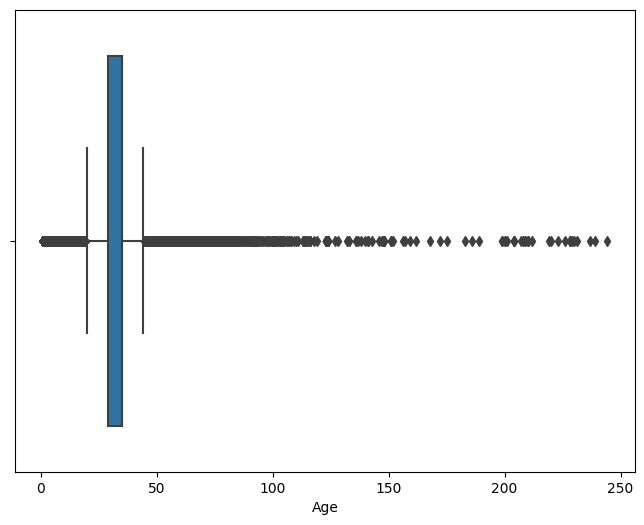

In [7]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=users['Age'])
plt.show()

C:\Users\dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


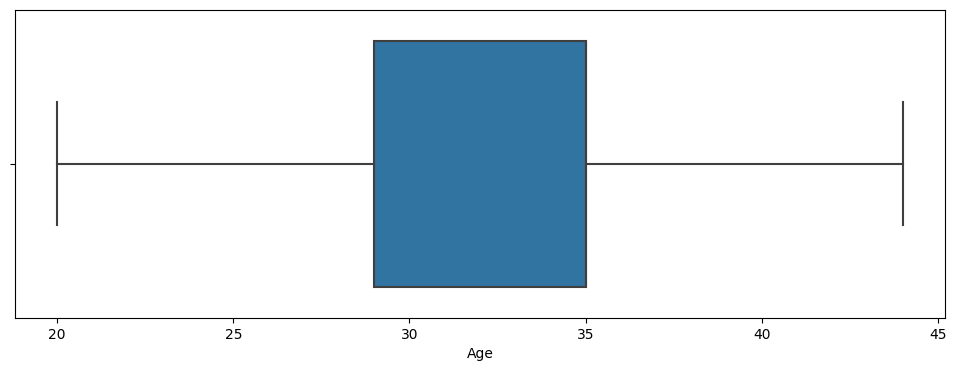

In [8]:
def remove_outliers(df, columns):
    df_no_outliers = df.copy()
    for col in columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower_limit = q1 - 1.5 * iqr
        upper_limit = q3 + 1.5 * iqr
        df_no_outliers[col] = df_no_outliers[col].apply(lambda x: x if x >= lower_limit and x <= upper_limit else (lower_limit if x < lower_limit else upper_limit))
    return df_no_outliers
df_no_outliers = remove_outliers(users,['Age'])
plt.figure(figsize=(12, 4))
sns.boxplot(x=df_no_outliers['Age'])
plt.show()

In [9]:
df_no_outliers['Age'].describe()

count    278858.000000
mean         33.573134
std           7.095724
min          20.000000
25%          29.000000
50%          35.000000
75%          35.000000
max          44.000000
Name: Age, dtype: float64

In [10]:
df_no_outliers['Age'].isna().sum()

0

In [11]:
users['Age'] = df_no_outliers['Age']

In [12]:
books = pd.read_csv('Livres.csv')

In [13]:
books.tail(15)

,ISBN,title,author,imgUrl,category_name
248092,020130998X,The Unified Modeling Language Reference Manual...,James Rumbaugh,http://images.amazon.com/images/P/020130998X.0...,Computers & Technology
248093,2268032019,Petite histoire de la dÃ?Â©sinformation,Vladimir Volkoff,http://images.amazon.com/images/P/2268032019.0...,Literature & Fiction
248094,0684860112,Driving to Detroit: Memoirs of a Fast Woman,Lesley Hazleton,http://images.amazon.com/images/P/0684860112.0...,Engineering & Transportation
248095,3442150663,Der Mossad.,Victor Ostrovsky,http://images.amazon.com/images/P/3442150663.0...,Biographies & Memoirs
248096,0231128444,Slow Food(The Case For Taste),Carlo Petrini,http://images.amazon.com/images/P/0231128444.0...,"Cookbooks, Food & Wine"
248097,0520242335,Strong Democracy : Participatory Politics for ...,Benjamin R. Barber,http://images.amazon.com/images/P/0520242335.0...,Politics & Social Sciences
248098,0762412119,"Burpee Gardening Cyclopedia: A Concise, Up to ...",Allan Armitage,http://images.amazon.com/images/P/0762412119.0...,"Crafts, Hobbies & Home"
248099,1582380805,Tropical Rainforests: 230 Species in Full Colo...,"Allen M., Ph.D. Young",http://images.amazon.com/images/P/1582380805.0...,"Health, Fitness & Dieting"
248100,1845170423,Cocktail Classics,David Biggs,http://images.amazon.com/images/P/1845170423.0...,"Cookbooks, Food & Wine"
248101,014002803X,Anti Death League,Kingsley Amis,http://images.amazon.com/images/P/014002803X.0...,Romance


In [14]:
books['title'].nunique()

239544

In [15]:
books.shape[0]

248107

In [16]:
books['title'] = books['title'].str.lower()
books['author'] = books['author'].str.lower()


In [17]:
duplicate_rows = books.duplicated(subset=['title'])
duplicates = books[duplicate_rows]
print("Duplicate Rows based on 'Column1' and 'Column2':")
print(duplicates)

Duplicate Rows based on 'Column1' and 'Column2':
              ISBN                                             title  \
478     039914739X                                      isle of dogs   
536     0385490992                                 the street lawyer   
848     0786890436  the diary of ellen rimbauer: my life at rose red   
1211    067168390X                                     lonesome dove   
1265    0590542443   the amber spyglass (his dark materials, book 3)   
...            ...                                               ...   
247863  843928036X                            el signo de los cuatro   
247903  0684179857                  halliwell's filmgoer's companion   
247933  0801554543                         nothing ever happens here   
247961  086713089X                               classic fairy tales   
248065  1902852036                               all the queen's men   

                           author  \
478     patricia daniels cornwell   
536         

In [18]:
# Drop duplicate rows based on specific columns (e.g., 'Column1' and 'Column2')
books = books.drop_duplicates(subset=['title'])
duplicate_rows = books.duplicated(subset=['title'])
duplicates = books[duplicate_rows]
print("Duplicate Rows based on 'Column1' and 'Column2':")
print(duplicates)

Duplicate Rows based on 'Column1' and 'Column2':
Empty DataFrame
Columns: [ISBN, title, author, imgUrl, category_name]
Index: []


In [19]:
books.isna().sum()

ISBN             0
title            0
author           0
imgUrl           0
category_name    0
dtype: int64

In [20]:
ratings = pd.read_csv('Ratings.csv')

In [21]:
ratings.tail(15)

,User-ID,ISBN,Book-Rating
1149765,276704,0440206529,0
1149766,276704,0441007813,0
1149767,276704,0446353957,0
1149768,276704,0446605409,0
1149769,276704,059032120X,0
1149770,276704,0679752714,0
1149771,276704,0743211383,7
1149772,276704,080410526X,0
1149773,276704,0806917695,5
1149774,276704,0876044011,0


<h3>Making the Historique of each USER</h3>

In [22]:
# Merge 'ratings' and 'books' DataFrames on 'ISBN'
merged_data = pd.merge(ratings, books, on='ISBN', how='inner')

# Group by 'User-ID' and get unique categories for each user
user_categories = merged_data.groupby('User-ID')['category_name'].unique()

# If you want the result as a DataFrame with 'User-ID' and 'Category' columns
user_historique = user_categories.reset_index(name='Historique')

# Display the result
user_historique.tail(20)


,User-ID,Historique
79741,278784,[Religion & Spirituality]
79742,278788,[LGBTQ+ eBooks]
79743,278789,"[Children's eBooks, LGBTQ+ eBooks]"
79744,278795,[Literature & Fiction]
79745,278798,"[Mystery, Thriller & Suspense, Biographies & M..."
79746,278800,"[Mystery, Thriller & Suspense]"
79747,278807,"[Mystery, Thriller & Suspense]"
79748,278813,[History]
79749,278818,"[Children's eBooks, Biographies & Memoirs]"
79750,278819,"[Mystery, Thriller & Suspense]"


In [23]:
books.head()

,ISBN,title,author,imgUrl,category_name
0,0195153448,classical mythology,mark p. o. morford,http://images.amazon.com/images/P/0195153448.0...,Education & Teaching
1,0002005018,clara callan,richard bruce wright,http://images.amazon.com/images/P/0002005018.0...,Religion & Spirituality
2,0374157065,flu: the story of the great influenza pandemic...,gina bari kolata,http://images.amazon.com/images/P/0374157065.0...,Science & Math
3,0393045218,the mummies of urumchi,e. j. w. barber,http://images.amazon.com/images/P/0393045218.0...,Biographies & Memoirs
4,0399135782,the kitchen god's wife,amy tan,http://images.amazon.com/images/P/0399135782.0...,Biographies & Memoirs


<h2>Content-based filtering </h2>

<h3>Similarity between books</h3>

<h5>Using KNN</h5>

In [24]:
# Combine features
books['combined_features'] = books['title'] + ' ' + books['author'] + ' ' + books['category_name']

# Text vectorization using countvectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(books['combined_features'])

# Dimensionality reduction using TruncatedSVD
svd = TruncatedSVD(n_components=50)
X = svd.fit_transform(X)

# Initialize Nearest Neighbors model
k_neighbors = 10
knn_model = NearestNeighbors(n_neighbors=k_neighbors, metric='cosine')
knn_model.fit(X)

# Function to find k-nearest neighbors for a given book title
def find_neighbors(user_id, book_title, exclude_rated=True):
    query_result = books[books['title'].str.lower() == book_title.lower()]
    
    if query_result.empty:
        print(f"No match found for book title: {book_title}")
        return pd.DataFrame()  # Return an empty DataFrame or handle it as needed

    query_book_index = query_result.index[0]

    # Use NumPy array indexing to access the feature vector
    query_book_features = X[query_book_index].reshape(1, -1)
    distances, indices = knn_model.kneighbors(query_book_features)
    neighbors = books.iloc[indices[0]][['ISBN', 'title', 'author', 'category_name']]

    # Filter out books that the user has already rated
    if exclude_rated:
        user_rated_books = ratings[ratings['User-ID'] == user_id]['ISBN'].tolist()
        neighbors = neighbors[~neighbors['ISBN'].isin(user_rated_books)]

    return neighbors

# Example
user_id_to_recommend = 276704
query_book_title = 'classical mythology'

result_knn = find_neighbors(user_id_to_recommend, query_book_title.lower())
print(result_knn)


              ISBN                       title                  author  \
0       0195153448         classical mythology      mark p. o. morford   
212336  0697412806  education: 98/99 (25th ed)            fred schultz   
99597   0812511921        alternate presidents            mike resnick   
9112    074324141X        kaplan gre exam 2004                  kaplan   
191660  0026258102          recoveries: a poem  theodore russell weiss   
178619  2070362035       l'education europeene             romain gary   
139144  0748735143   essential teaching skills          chris kyriacou   
239611  0812211251        archaeology workbook           steve daniels   
48343   0446394777        college dorm workout         joyce l. vedral   
127996  0751524786                indecent act           maria barrett   

               category_name  
0       Education & Teaching  
212336  Education & Teaching  
99597   Education & Teaching  
9112    Education & Teaching  
191660  Education & Teaching  

<h5>Using kmeans algorithm</h5>

In [25]:
from sklearn.cluster import KMeans

# Combine features
books['combined_features'] = books['title'] + ' ' + books['author'] + ' ' + books['category_name']

# Text vectorization using countvectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(books['combined_features'])

# Dimensionality reduction using TruncatedSVD
svd = TruncatedSVD(n_components=50)
X_svd = svd.fit_transform(X)

# Cluster books using K-Means
n_clusters = 33  # You can adjust the number of clusters based on your data
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
book_clusters = kmeans.fit_predict(X_svd)

# Add the cluster information to the books DataFrame
books['cluster'] = book_clusters

# Function to find books in the same cluster for a given book title
def find_cluster_books(book_title):
    query_result = books[books['title'].str.lower() == book_title.lower()]
    
    if query_result.empty:
        print(f"No match found for book title: {book_title}")
        return pd.DataFrame()  # Return an empty DataFrame or handle it as needed

    query_cluster = query_result['cluster'].values[0]

    # Retrieve books in the same cluster
    cluster_books = books[books['cluster'] == query_cluster]

    return cluster_books[['ISBN', 'title', 'author', 'category_name']]

# Example
query_book_title = 'classical mythology'
result = find_cluster_books(query_book_title.lower())
print(result)


C:\Users\dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


              ISBN                                              title  \
0       0195153448                                classical mythology   
32      3442410665                                  sturmzeit. roman.   
359     0198320264          julius caesar (oxford school shakespeare)   
502     080521061X  montessori today: a comprehensive approach to ...   
539     0590419625                  the teacher from the black lagoon   
...            ...                                                ...   
247794  0844212652                 teaching french: a practical guide   
247877  039331720X  snowshoeing: a trailside guide (trailside seri...   
248002  1853914266  really useful: student book (really useful ser...   
248061  0304329045  how can you write a poem when you are dying of...   
248090  1874166633  introducing nietzsche (foundations in children...   

                     author         category_name  
0        mark p. o. morford  Education & Teaching  
32           charlo

In [26]:
user_profile = pd.merge(users, user_historique, on='User-ID', how='inner')

In [27]:
user_profile.head()

,User-ID,Location,Age,Historique
0,2,"stockton, california, usa",20.0,[Education & Teaching]
1,8,"timmins, ontario, canada",35.0,"[Religion & Spirituality, Science & Math, Biog..."
2,9,"germantown, tennessee, usa",35.0,"[Mystery, Thriller & Suspense, Humor & Enterta..."
3,10,"albacete, wisconsin, spain",26.0,"[Cookbooks, Food & Wine]"
4,12,"fort bragg, california, usa",35.0,[Reference]


<h2>Collaborative filtering user-based</h2>

<h3>Similar users</h3>

In [28]:
# Combine features
sim_users = user_profile.copy()
# Assuming you have a DataFrame named 'sim_users' with an 'Age' column
sim_users['Age'] = sim_users['Age'].astype(str)

sim_users['Historique'] = sim_users.apply(lambda row: ' '.join(map(str, row['Historique'])), axis=1)
sim_users['combined_features'] = sim_users['Location'] + ' ' + sim_users['Age'] + ' ' + sim_users['Historique']
# Text vectorization using TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(sim_users['combined_features'])

# Dimensionality reduction using TruncatedSVD (optional, but can be useful for high-dimensional data)
svd = TruncatedSVD(n_components=700)
X = svd.fit_transform(X)

# Initialize Nearest Neighbors model
k_neighbors = 500
knn_model = NearestNeighbors(n_neighbors=k_neighbors, metric='cosine')
knn_model.fit(X)
# Function to find k-nearest neighbors for a given book title
def find_neighbors_sim(user_id):
    try:
        query_user_index = sim_users[sim_users['User-ID'] == user_id].index[0]
    except IndexError:
        print(f"User ID {user_id} not found in sim_users.")
        return None

    query_user_features = X[query_user_index].reshape(1, -1)
    distances, indices = knn_model.kneighbors(query_user_features)

    if len(indices) == 0:
        print("No neighbors found.")
        return None

    neighbors = users.iloc[indices[0]][['User-ID']]
    return neighbors

# Example: Find k-nearest neighbors for a specific user ID
user_id_to_recommend = 276704  # Replace with the actual user ID
result = find_neighbors_sim(user_id_to_recommend)
print(result)

       User-ID
79133    79134
12832    12833
74202    74203
6922      6923
64216    64217
...        ...
42626    42627
6776      6777
43078    43079
76135    76136
26108    26109

[500 rows x 1 columns]


<h3>Books rated by similar users</h3>

In [29]:
user_books_df = pd.DataFrame(columns=['User-ID', 'ISBN', 'Book-Rating'])

# Populate the DataFrame with user information, book information, and ratings
for user_id in result['User-ID']:
    # Group by user ID and get a list of unique ISBNs
    user_books = ratings[ratings['User-ID'] == user_id][['ISBN', 'Book-Rating']].copy()
    user_books['User-ID'] = user_id
    user_books_df = pd.concat([user_books_df, user_books])

# Include books already rated by the target user
user_books_to_recommend = ratings[ratings['User-ID'] == user_id_to_recommend][['ISBN', 'Book-Rating']].copy()
user_books_to_recommend['User-ID'] = user_id_to_recommend
user_books_df = pd.concat([user_books_df, user_books_to_recommend])

# Reset index of the final DataFrame
user_books_df.reset_index(drop=True, inplace=True)

# Display the resulting DataFrame
user_books_df.head()


,User-ID,ISBN,Book-Rating
0,57644,0743251423,0
1,57644,1902825454,0
2,57644,3257202857,0
3,57644,3426615118,0
4,57644,3426615177,0


In [30]:
user_books_df.shape[0]

867

In [31]:
# Merge user_books_df with books on the common column 'ISBN'
sim_users_books_info = pd.merge(user_books_df, books, on='ISBN', how='inner')

# Display the merged dataframe
sim_users_books_info.head()


,User-ID,ISBN,Book-Rating,title,author,imgUrl,category_name,combined_features,cluster
0,57644,0743251423,0,who moved my soap? : the ceo's guide to surviv...,andy borowitz,http://images.amazon.com/images/P/0743251423.0...,Law,who moved my soap? : the ceo's guide to surviv...,3
1,57644,1902825454,0,the xenophobe's guide to the swiss,paul bilton,http://images.amazon.com/images/P/1902825454.0...,Travel,the xenophobe's guide to the swiss paul bilton...,13
2,57644,3257202857,0,efraim,alfred andersch,http://images.amazon.com/images/P/3257202857.0...,Children's eBooks,efraim alfred andersch Children's eBooks,2
3,57644,3426615118,0,freischwimmer: roman,markus seidel,http://images.amazon.com/images/P/3426615118.0...,Children's eBooks,freischwimmer: roman markus seidel Children's ...,2
4,57644,3426615177,0,nachttrã?â¼mmer.,matthias triebel,http://images.amazon.com/images/P/3426615177.0...,LGBTQ+ eBooks,nachttrã?â¼mmer. matthias triebel LGBTQ+ eBooks,16


<h3>Unsupervised learning</h3>

<h4>Apriori</h4>

In [32]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# Assuming 'sim_users_books_info' contains information about book purchases

# Group by 'User-ID' and aggregate the books into lists
basket_sets = sim_users_books_info.groupby('User-ID')['title'].agg(list)

# Convert the grouped data to a list of lists
baskets = basket_sets.tolist()

# Use TransactionEncoder to convert the data to a format suitable for Apriori
te = TransactionEncoder()
te_ary = te.fit(baskets).transform(baskets)
df = pd.DataFrame(te_ary, columns=te.columns_)

# Apply the Apriori algorithm
min_support = 0.013
frequent_itemsets = apriori(df, min_support=min_support, use_colnames=True)

# Generate association rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=1)

# Display the frequent itemsets
#print(frequent_itemsets)
#print(rules)

df.head()

,"10,000 dreams interpreted or what's in a dream",12 monkeys: a novel,16 lighthouse road,24 hours,"\my husband's trying to kill me!\""""",a bus of my own,"a child called \it\"": one child's courage to survive""",a civil campaign,a desert of pure feeling (vintage contemporaries),a fire upon the deep (zones of thought),...,windy city blues (v.i. warshawski novels (paperback)),winter prey,wirtschaftspolitik.,wirtschaftspolitik. eine praxisorientierte einfã?â¼hrung.(7.auflage),wolf tracks,women in love (twentieth century classics s.),women's history of the world,wrench,x-rated,zen and the art of motorcycle maintenance: an inquiry into values
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [33]:
# Convert the data to a binary transaction format
basket_sets_a = sim_users_books_info.groupby(['User-ID', 'title']).size().unstack().reset_index().fillna(0).set_index('User-ID').applymap(lambda x: 1 if x > 0 else 0)

# Apply the Apriori algorithm
frequent_itemsets = apriori(basket_sets_a, min_support=0.013, use_colnames=True)

# Generate association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# Display the frequent itemsets
print(frequent_itemsets)
# print(rules)

     support                                           itemsets
0   0.013793                                     (anil's ghost)
1   0.020690  (divine secrets of the ya-ya sisterhood: a novel)
2   0.013793                        (girl with a pearl earring)
3   0.020690                                       (icy sparks)
4   0.013793                          (interpreter of maladies)
5   0.013793                                (lord of the flies)
6   0.013793                                      (open season)
7   0.013793                                       (rising sun)
8   0.013793  (where the heart is (oprah's book club (paperb...
9   0.013793                                      (wild animus)
10  0.013793  (zen and the art of motorcycle maintenance: an...


C:\Users\dell\AppData\Local\Temp\ipykernel_3188\1385047870.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket_sets_a = sim_users_books_info.groupby(['User-ID', 'title']).size().unstack().reset_index().fillna(0).set_index('User-ID').applymap(lambda x: 1 if x > 0 else 0)
C:\Users\dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


<h4>FPGROWTH</h4>

In [34]:
# Convert the data to a binary transaction format
basket_sets_f = sim_users_books_info.groupby(['User-ID'])['title'].apply(list).reset_index()

# Convert the list of lists to a DataFrame
basket_df = pd.get_dummies(basket_sets_f['title'].apply(pd.Series).stack()).groupby(level=0).max()

# Apply the FP-Growth algorithm
frequent_itemsets = fpgrowth(basket_df, min_support=0.013, use_colnames=True)

# Generate association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# Display the association rules
print(frequent_itemsets)


     support                                           itemsets
0   0.013793                                     (anil's ghost)
1   0.020690  (divine secrets of the ya-ya sisterhood: a novel)
2   0.013793                                (lord of the flies)
3   0.020690                                       (icy sparks)
4   0.013793                                      (open season)
5   0.013793                                      (wild animus)
6   0.013793                          (interpreter of maladies)
7   0.013793  (where the heart is (oprah's book club (paperb...
8   0.013793                                       (rising sun)
9   0.013793                        (girl with a pearl earring)
10  0.013793  (zen and the art of motorcycle maintenance: an...


In [1]:
# # Group by 'User-ID' and collect titles in a list
# basket_sets_e = sim_users_books_info.groupby('User-ID')['title'].apply(list).reset_index()

# # Convert the 'title' lists to a DataFrame
# dataset = pd.DataFrame(basket_sets_e['title'].tolist(), index=basket_sets['User-ID'])

# # Display the resulting dataset
# dataset.head()


In [ ]:
# eclat = ECLAT(data=dataset)
# # DataFrame of binary values
# eclat.df_bin.as_type(int)

In [ ]:
# items_total = eclat.df_bin.astype(int).sum(axis=0)
# items_total